[**Demo %s**](#demo-nlsq-MM)

In [2]:
m = 25;
s = range(0.05, 6, length=m)
ŵ = @. 2 * s / (0.5 + s)                      # exactly on the curve
w = @. ŵ + 0.15 * cos(2 * exp(s / 16) * s);     # smooth noise added

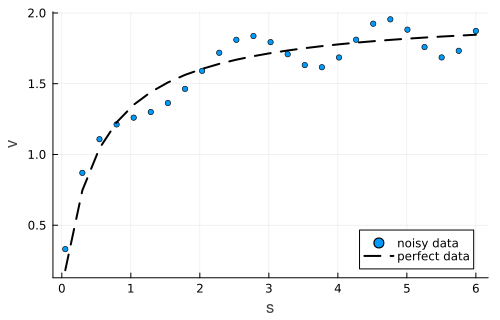

In [3]:
scatter(s, w, label="noisy data",
    xlabel="s", ylabel="v", leg=:bottomright)
plot!(s, ŵ, l=:dash, color=:black, label="perfect data")

```{index} ! Julia; destructuring
```

The idea is to pretend that we know nothing of the origins of this data and use nonlinear least squares to find the parameters in the theoretical model function $v(s)$. In {eq}`nlsq-misfit`, the $s$ variable plays the role of $t$, and $v$ plays the role of $g$.
```{tip}
:class: dropdown
Putting comma-separated values on the left of an assignment will **destructure** the right-hand side, drawing individual assignments from entries of a vector, for example.
```

In [4]:
function misfit(x)
    V, Km = x   # rename components for clarity
    return @. V * s / (Km + s) - w
end

misfit (generic function with 1 method)

In the Jacobian the derivatives are with respect to the parameters in $\mathbf{x}$.

In [5]:
function misfitjac(x)
    V, Km = x   # rename components for clarity
    J = zeros(m, 2)
    J[:, 1] = @. s / (Km + s)              # dw/dV
    J[:, 2] = @. -V * s / (Km + s)^2         # dw/d_Km
    return J
end

misfitjac (generic function with 1 method)

In [6]:
x₁ = [1, 0.75]
x = FNC.newtonsys(misfit, misfitjac, x₁)

@show V, Km = x[end]  # final values

(V, Km) = x[end] = [1.968652598378229, 0.4693037307416775]

2-element Vector{Float64}:
 1.968652598378229
 0.4693037307416775

The final values are reasonably close to the values $V=2$, $K_m=0.5$ that we used to generate the noise-free data. Graphically, the model looks close to the original data.

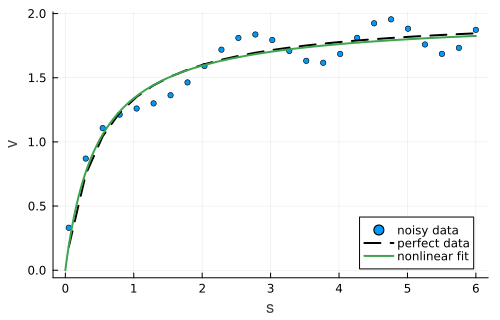

In [7]:
model(s) = V * s / (Km + s)
plot!(model, 0, 6, label="nonlinear fit")

For this particular model, we also have the option of linearizing the fit process. Rewrite the model as 

```{math}
:enumerated: false
\frac{1}{w} = \frac{\alpha}{s} + \beta = \alpha \cdot s^{-1} + \beta
```

for the new fitting parameters $\alpha=K_m/V$ and $\beta=1/V$. This corresponds to the misfit function whose entries are

$$f_i([\alpha,\beta]) = \left(\alpha \cdot \frac{1}{s_i} + \beta\right) - \frac{1}{w_i}$$
for $i=1,\ldots,m$. Although this misfit is nonlinear in $s$ and $w$, it's linear in the unknown parameters $\alpha$ and $\beta$. This lets us pose and solve it as a linear least-squares problem.

In [8]:
A = [s .^ (-1) s .^ 0]
u = 1 ./ w
α, β = A \ u

2-element Vector{Float64}:
 0.12476333709901538
 0.5713959100431231

The two fits are different because they do not optimize the same quantities.

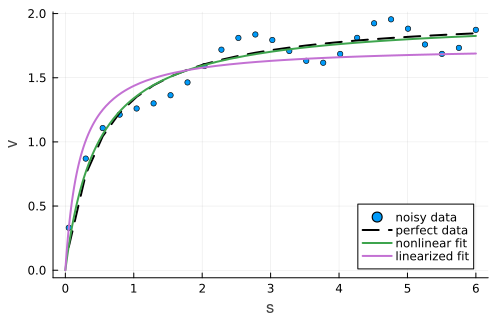

In [9]:
linmodel(x) = 1 / (β + α / x)
plot!(linmodel, 0, 6, label="linearized fit")

The truly nonlinear fit is clearly better in this case. It optimizes a residual for the original measured quantity rather than a transformed one we picked for algorithmic convenience.